In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 13.9 MB/s 
     |████████████████████████████████| 6.5 MB 55.3 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 66.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import transformers
from transformers import pipeline
from transformers import AutoTokenizer
import random as r
import spacy
import tensorflow as tf
import torch
from collections import Counter
from collections import defaultdict
import altair as alt
import math
import collections
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/W266-final-project/

/content/drive/My Drive/W266-final-project


In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result



## Generate POS tagging for SpaCy

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
base = '/content/drive/MyDrive/W266-final-project/data/BBC News Summary/News Articles/'
file = open(base + 'business' + '/' + '001' + '.txt')
txt = nlp(file.read())
print(txt)

In [ ]:
from collections import Counter
counts=[]
types=[]
for token in txt:
  if token.pos_ not in types:
    types.append(token.pos_)
  counts.append(token.pos_)
pd.DataFrame(Counter(counts))

In [ ]:
counts_dict = dict(Counter(counts))
counts_df = pd.DataFrame()
counts_df['POS'] = counts_dict.keys()
counts_df['counts'] = [counts_dict[k] for k in counts_dict.keys()]
counts_df

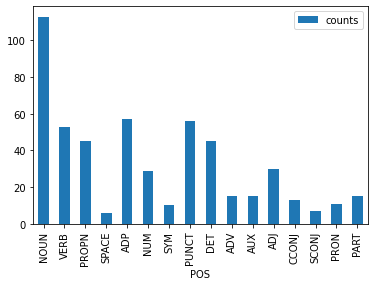

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline

counts_df.plot.bar(x='POS', y='counts')


# **Dataset creation**

In [ ]:
indicies_df = pd.read_csv('/content/drive/MyDrive/W266-final-project/indicies.csv')
indicies_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
indicies_df

,business,entertainment,politics,sport,tech
0,384,29,273,131,276
1,315,97,208,110,329
2,267,117,192,502,51
3,25,358,186,268,160
4,112,349,190,64,73
...,...,...,...,...,...
95,123,266,350,19,246
96,225,264,221,458,293
97,372,246,35,419,295
98,35,295,12,214,216


In [ ]:
def get_types(base='/content/drive/MyDrive/W266-final-project/data/BBC News Summary/', summ_type='Summaries/', indicies_df=indicies_df):
  '''
  takes in base location of file directory, and summary types
  returns DF indexed by article number in indicies_df
  '''
  nlp = spacy.load("en_core_web_sm")
  final_df = indicies_df.copy()
  for t in indicies_df.columns:
    #holds the text for each articles
    txt1=[] 
    pos1 = []
    dep1 = []
    stop1 = []
    for i in indicies_df[t]: #iterates through each article
      if i<10:
        i='00' + str(i)
      elif i<100:
        i='0'+str(i)
      else:
        i=str(i)
      file = open(base + summ_type + t + '/' + i + '.txt', 'r', errors='replace')
      txt = nlp(file.read())
      #count each indivual POS in the text
      pos_types=[]
      dep_types = []
      is_stop_lst = []
      for token in txt:  #takes the parts adds the strings to a list
        pos_types.append(token.pos_)
        dep_types.append(token.dep_)
        is_stop_lst.append(token.is_stop)
      #takes the lists of strings, adds them to a master list for each category
      pos1.append(pos_types) 
      dep1.append(dep_types)
      stop1.append(is_stop_lst)
      txt1.append(txt)
    #add to DF- each column- whats in the list
    final_df[summ_type + '-'+ 'text'] = txt1
    final_df[summ_type + '-' + t+'-POS'] = pos1
    final_df[summ_type + '-' + t+'-DEP'] = dep1
    final_df[summ_type + '-' + t+'-STOP'] = stop1
    # list( list(article parts))
  return final_df


In [ ]:
df_article = get_types(summ_type='News Articles/')
df = get_types()
df_final = pd.merge(df, df_article, how='inner', on=['business', 'entertainment', 'politics', 'sport', 'tech'])
df_final

In [ ]:
def def_value():
    return 0

def get_counts(counts_df) :

  final_df = pd.DataFrame()

  cols = ['Summaries/-business-POS', 'Summaries/-business-DEP',
       'Summaries/-business-STOP', 'Summaries/-entertainment-POS',
       'Summaries/-entertainment-DEP', 'Summaries/-entertainment-STOP',
       'Summaries/-politics-POS', 'Summaries/-politics-DEP',
       'Summaries/-politics-STOP', 'Summaries/-sport-POS',
       'Summaries/-sport-DEP', 'Summaries/-sport-STOP', 'Summaries/-tech-POS',
       'Summaries/-tech-DEP', 'Summaries/-tech-STOP', 'News Articles/-text',
       'News Articles/-business-POS', 'News Articles/-business-DEP',
       'News Articles/-business-STOP', 'News Articles/-entertainment-POS',
       'News Articles/-entertainment-DEP', 'News Articles/-entertainment-STOP',
       'News Articles/-politics-POS', 'News Articles/-politics-DEP',
       'News Articles/-politics-STOP', 'News Articles/-sport-POS',
       'News Articles/-sport-DEP', 'News Articles/-sport-STOP',
       'News Articles/-tech-POS', 'News Articles/-tech-DEP',
       'News Articles/-tech-STOP']

  for c in cols:
    cnts = defaultdict(def_value)
    for i in range(len(counts_df[c])):
      #get the percentage of total for each POS
      cnt = Counter(counts_df[c][i])
      total = sum(cnt.values())
      for i in cnt.keys():
        cnt[i] /= total
      #add the counts to a running dictionary
      for k in cnt:
        cnts[k] += cnt[k]
    #finally divide by 100 (the number of articles in the dataset)
    for k in cnts:
      cnts[k] = cnts[k]/100
    final_df[c+' averages'] = [cnts] 
  return final_df



In [ ]:
counts_df = get_counts(df_final)
#get the averages for each



curr = 0
counts_df

0.9999999999999999

In [ ]:
counts_df['Summaries/-business-POS averages'][0]

defaultdict(<function __main__.def_value>,
            {'ADJ': 0.06450871204439532,
             'ADP': 0.10123232953605278,
             'ADV': 0.02403143682976803,
             'AUX': 0.04223646759555383,
             'CCONJ': 0.0201317244315902,
             'DET': 0.09810854077808585,
             'INTJ': 9.259259259259259e-05,
             'NOUN': 0.20870219530195108,
             'NUM': 0.03360318892283966,
             'PART': 0.03305124033230927,
             'PRON': 0.013789283521798203,
             'PROPN': 0.11000191917996656,
             'PUNCT': 0.1075085833638683,
             'SCONJ': 0.017924515818040374,
             'SPACE': 6.944444444444444e-05,
             'SYM': 0.0073871852314568165,
             'VERB': 0.11759033704498352,
             'X': 3.0303030303030302e-05})

# **POS Masking**

- Create dictionary to put into mas_pos fcn and use it to compute the prob. of masking certain terms based on average distribution of the terms in the summary
  - mask each POS with prob gotten from the dictionary
  - hopefully this should result in a similar prob. distribution to the summary
  - dictionary is made up keys which are the columns, values are dictionaries with POS for keys, prob for values

- Implement k-fold articles of 100 random articles to exmaine variance among different groups of articles

In [ ]:
def mask_pos(txt, avgs_df, category):

  '''

  mask_pos is a method that masks specific parts of speech using the huggingface tokenizer using a masking probability of prob. 
  It takes in:
  - spacy english language object text object, 
  - avgs_df a dictionary, keys are the list of POS, values are the repsective prob. of the POS obtained from averaging 100 articles
  - category- The category of the article

  '''

  mask_dict = avgs_df[category][0]

  tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
  #get POS for each word in the text
  lst=[]
  #tt = txt.split()
  #txt = nlp('My name is John.')
  for token in txt:
    lst.append(token.pos_)

  #masks the words with prob of the associated POS 
    #logic to create masks- if it's in the masking list there the prob. of masking associated with the avg distribution of the work
  word_idxs_in_sent_test = [t for t in range(len(lst)) if r.random() <= mask_dict[lst[t]]] #want to make the words if the random number generated is less than or equal to the prob of that word occuring in the summary


  #contains the tokenized text 
  encoded = tokenizer(str(txt), return_tensors="pt", padding=True)

  # For each sentence, set a subword token to True if it belongs to the POS group (becomes 0 in LongTensor)
  match_idxs = torch.LongTensor([wid in word_idxs_in_sent_test for wid in encoded.word_ids(0)])

  # Merge: if a word is zero in our custom match, merge, if not, use the original mask
  # This ensures that we mask the word IDs but keep the original mask for special tokens (cls, pad, etc.)
  merged = torch.where(match_idxs == 0, match_idxs, encoded["attention_mask"])


  # Create a map between words and corresponding token indices
  mapping = collections.defaultdict(list)
  current_word_index = -1
  current_word = None
  for idx, word_id in enumerate(encoded['input_ids'][0]):
      if word_id is not None:
          if word_id != current_word:
              current_word = word_id
              current_word_index += 1
          mapping[current_word_index].append(idx)

  labels= [1] * len(str(txt).split())
  input_ids=encoded['input_ids'][0]

  new_labels = [-100] * len(labels)
  for word_id in np.where(match_idxs)[0]:
    word_id = word_id.item()
    for idx in mapping[word_id]:
      #new_labels[idx] = labels[idx]
      input_ids[idx] = tokenizer.mask_token_id

  return  tokenizer.decode(encoded['input_ids'][0])


In [ ]:
#categories in our dataset
cats = ['tech']
#['business', 'entertainment', 'politics', 'sport', 'tech']
#the artciles in each category
limit = [401]
#[510, 386, 417, 511, 401]
#base directory for the articles
base = '/content/drive/MyDrive/W266-final-project/data/BBC News Summary/News Articles/'

#df containing the indicies we want to use
indicies_df = pd.read_csv('/content/drive/MyDrive/W266-final-project/indicies.csv')
indicies_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

#the final fine tuining DF
fine_tune_df = pd.DataFrame()

#df for each articles type
business_df = pd.DataFrame()
entertainment_df = pd.DataFrame()
politics_df = pd.DataFrame()
sport_df = pd.DataFrame()
tech_df = pd.DataFrame()

#the df containing the average POS values
counts_df = get_counts(df_final)
counts_df.rename(columns={'Summaries/-business-POS averages': 'business', 'Summaries/-entertainment-POS averages': 'entertainment', 
                          'Summaries/-politics-POS averages': 'politics', 'Summaries/-sport-POS averages': 'sport', 
                          'Summaries/-tech-POS averages': 'tech'}, inplace=True)


#intialize the spacy library
nlp = spacy.load("en_core_web_sm")


for j,c in enumerate(cats):
  masked = []
  org = []
  indicies = []
  for i in range(1, limit[j]):
    if i<10:
      i='00' + str(i)
    elif i<100:
      i='0' + str(i) 
    else:
      i=str(i)
    indicies.append(i)
    file = open(base + c + '/' + i + '.txt', 'r', errors='replace')
    txt = nlp(file.read())
    org.append(txt)
    masked.append(mask_pos(txt=txt, avgs_df=counts_df, category=c))
  if c == 'business':
    business_df[c+' indicies'] = indicies
    business_df[c+' masked'] = masked
    business_df[c+' original'] = org
  elif c == 'entertainment':
    entertainment_df[c+' indicies'] = indicies
    entertainment_df[c+' masked'] = masked
    entertainment_df[c+' original'] = org
  elif c == 'politics':
    politics_df[c+' indicies'] = indicies
    politics_df[c+' masked'] = masked
    politics_df[c+' original'] = org
  elif c == 'sport':
    sport_df[c+' indicies'] = indicies
    sport_df[c+' masked'] = masked
    sport_df[c+' original'] = org
  elif c == 'tech':
    tech_df[c+' indicies'] = indicies
    tech_df[c+' masked'] = masked
    tech_df[c+' original'] = org
  #'entertainment', 'politics', 'sport', 'tech'

tech_df.to_csv('tech_masked_articles.csv')

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1644 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1073 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1095 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1104 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

In [ ]:
#limit = [510, 386, 417, 511, 401]
pd.read_csv('/content/drive/MyDrive/W266-final-project/business_masked_articles.csv').head()

,Unnamed: 0,business indicies,business masked,business original
0,0,1,<s>Ad<mask> boost Time Warner profit\n\nQu<mas...,Ad sales boost Time Warner profit\n\nQuarterly...
1,1,2,<s><mask><mask> gains on<mask><mask> speech\n\...,Dollar gains on Greenspan speech\n\nThe dollar...
2,2,3,<s>Yukos unit buyer faces loan claim\n\nThe ow...,Yukos unit buyer faces loan claim\n\nThe owner...
3,3,4,<s>High fuel prices hit BA's profits\n\nBritis...,High fuel prices hit BA's profits\n\nBritish A...
4,4,5,<s>Pernod<mask> talk lifts Domecq\n\nShares in...,Pernod takeover talk lifts Domecq\n\nShares in...


In [ ]:
indicies.append(i)
file = open(base + c + '/' + i + '.txt', 'r', errors='replace')
txt = nlp(file.read())
org.append(txt)
masked.append(mask_pos(txt=txt, avgs_df=counts_df, category=c))

In [ ]:
i

'011'

Subword indices of matching word tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1])


tensor([[1, 0, 0, 0, 1, 0, 0, 0, 0, 1]])


In [ ]:
pip install git+https://github.com/huggingface/transformers

In [ ]:
import collections
import numpy as np
import transformers
import transformers.data
from transformers.data import default_data_collator


In [ ]:

wwm_probability = 0.2

def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id

    return default_data_collator(features)

## Generate Training Data


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/W266-final-project/indicies.csv')
test_df

,Unnamed: 0,Unnamed: 0.1,business,entertainment,politics,sport,tech
0,0,0,384,29,273,131,276
1,1,1,315,97,208,110,329
2,2,2,267,117,192,502,51
3,3,3,25,358,186,268,160
4,4,4,112,349,190,64,73
...,...,...,...,...,...,...,...
95,95,95,123,266,350,19,246
96,96,96,225,264,221,458,293
97,97,97,372,246,35,419,295
98,98,98,35,295,12,214,216


In [ ]:
def get_random(lower, upper):
  return r.randint(lower, upper)

Fine tuning data will correspond to the same number in the test data % 9. IE
fine tuning 1 will correspond to test data 1 (1%9=1), also correpsond to test data 28 (28%9=4)

In [ ]:
28%9

1

In [ ]:
cols = ['business', 'entertainment', 'politics', 'sport', 'tech']
limit = [510, 386, 417, 511, 401]

#create 30 random sets of 100 indicies for testing purposes
test_df = pd.DataFrame()
for n in range(30):
  for i,c in enumerate(cols):
    j = n%9
    existing = np.array(train_df[c+'-'+str(j)])
    arr = np.array([])
    for j in range(100):
      r1 = get_random(1, limit[i])
      while r1 in existing:
        r1 = get_random(1, limit[i])
      arr = np.append(arr, r1)
      existing = np.append(existing, r1)
    test_df[c+'-'+str(n)] = arr
test_df.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Index(['business-0', 'entertainment-0', 'politics-0', 'sport-0', 'tech-0',
       'business-1', 'entertainment-1', 'politics-1', 'sport-1', 'tech-1',
       ...
       'business-28', 'entertainment-28', 'politics-28', 'sport-28', 'tech-28',
       'business-29', 'entertainment-29', 'politics-29', 'sport-29',
       'tech-29'],
      dtype='object', length=150)

In [ ]:
limit = {'business': 510, 'entertainment': 386, 'politics': 417, 'sport': 511, 'tech': 401}
for c in train_df.columns:
  if train_df[c].max() > limit[c[:-2]]:
    print('ERROR')
    print(c, train_df[c].max())
    break
print('No Error')

No Error


In [ ]:
test_df[test_df.duplicated()==True]

,business-0,entertainment-0,politics-0,sport-0,tech-0,business-1,entertainment-1,politics-1,sport-1,tech-1,business-2,entertainment-2,politics-2,sport-2,tech-2,business-3,entertainment-3,politics-3,sport-3,tech-3,business-4,entertainment-4,politics-4,sport-4,tech-4,business-5,entertainment-5,politics-5,sport-5,tech-5,business-6,entertainment-6,politics-6,sport-6,tech-6,business-7,entertainment-7,politics-7,sport-7,tech-7,business-8,entertainment-8,politics-8,sport-8,tech-8,business-9,entertainment-9,politics-9,sport-9,tech-9,business-10,entertainment-10,politics-10,sport-10,tech-10,business-11,entertainment-11,politics-11,sport-11,tech-11,business-12,entertainment-12,politics-12,sport-12,tech-12,business-13,entertainment-13,politics-13,sport-13,tech-13,business-14,entertainment-14,politics-14,sport-14,tech-14,business-15,entertainment-15,politics-15,sport-15,tech-15,business-16,entertainment-16,politics-16,sport-16,tech-16,business-17,entertainment-17,politics-17,sport-17,tech-17,business-18,entertainment-18,politics-18,sport-18,tech-18,business-19,entertainment-19,politics-19,sport-19,tech-19,business-20,entertainment-20,politics-20,sport-20,tech-20,business-21,entertainment-21,politics-21,sport-21,tech-21,business-22,entertainment-22,politics-22,sport-22,tech-22,business-23,entertainment-23,politics-23,sport-23,tech-23,business-24,entertainment-24,politics-24,sport-24,tech-24,business-25,entertainment-25,politics-25,sport-25,tech-25,business-26,entertainment-26,politics-26,sport-26,tech-26,business-27,entertainment-27,politics-27,sport-27,tech-27,business-28,entertainment-28,politics-28,sport-28,tech-28,business-29,entertainment-29,politics-29,sport-29,tech-29


In [ ]:
test_df.to_csv('test_df_indicies.csv')

everything okay
